#### Load the dataset, preprocess it

In [1]:
from utils import *
from pandas_profiling import ProfileReport
np.random.seed(2020)

start = time.time()

dataset_df = get_table().dropna()
mask = (dataset_df['battery_plugged'] == 0) | (dataset_df['battery_plugged'] == 1)
dataset_df = dataset_df[mask]
# month in 8-12, 1-3, day in 1-31
# the following replacements keep 'monthday' chronologically sorted when hashed later
dataset_df['month'][dataset_df['month'] == 1] = 13
dataset_df['month'][dataset_df['month'] == 2] = 14
dataset_df['month'][dataset_df['month'] == 3] = 15
dataset_df['monthday'] = dataset_df['month']*100 + dataset_df['day']

text = 'packages_running_'
keep = [i for i in dataset_df.columns if text in i] + ['battery_plugged'] + ['battery_level'] + ['slot'] + ['monthday']
dataset_df = dataset_df[keep[:49] + keep[50:54] + keep[55:]]
dataset_df = dataset_df.dropna().T.drop_duplicates().T.reset_index()
dataset_df['md_key'] = hash_states(dataset_df['monthday'].to_numpy()[:,None])
dataset_df = dataset_df.drop(['monthday', 'slot'], axis=1)
dataset_df = dataset_df.drop(['packages_running_android', 'packages_running_com.android.calculator2',\
                             'packages_running_com.android.keychain','packages_running_com.android.packageinstaller',\
                             'packages_running_com.android.providers.applications', 'packages_running_com.android.providers.downloads',\
                             'packages_running_com.google.android.email', 'packages_running_edu.udo.cs.ess.mobidac.target',\
                             'packages_running_org.openintents.filemanager', 'packages_running_stream.android'], axis=1)

# get indices of dataset elements per day, so that we can use this partitioning of the data in training and validation
num_days = dataset_df['md_key'].to_numpy().max() + 1
# by day is a list that for each day, contains all dataset indices for that day
by_day = [np.array(dataset_df.index[dataset_df['md_key'] == i].tolist()) for i in range(num_days)]
# keep only days with at least 5 samples
by_day_filtered = [item for item in by_day if len(item) > 4]
# we can access day i by calling dataset_df.loc[by_day[i]]


# in this state space, battery plugged is the last column: activity_vectors[:,-1]
activity_vectors = dataset_df.drop(['index', 'battery_level', 'md_key'], axis=1).to_numpy()
targets = dataset_df['battery_level'].to_numpy()
print('Activity vectors shape:', activity_vectors.shape)
print('Targets shape:', targets.shape)
#profile = ProfileReport(dataset_df, title="Filtered Profiling Report")
#profile.to_file("filtered_report.html")

i = 101
j = 3
print(by_day_filtered[i][j])
A = activity_vectors[by_day_filtered[i]][j]
B = dataset_df.iloc[by_day_filtered[i][j]].values[1:-2]
print(B)
print(np.allclose(A,B))

Activity vectors shape: (2445, 35)
Targets shape: (2445,)
2320
[1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0.]
True


##### Transform the state space

This is an interface for attempting some clustering, or some other informed pruning of the state space. It is however necessary that the outputs of the state space transform are still binary vectors, as this guarantees compatibility with later modules. Also, the final column activity_vectors$[:,-1]$ should remain untouched, as it stores the battery_plugged state which we need for the regressor split later.

In [2]:
def state_space_transform(activity_vectors,targets=None, number_classes=2, mode='Id'):
    """
    Transforms/prunes the state space of the input.
    
    Possible states are 'Id', 'Clown', 'Gain','Gini'.
    !Gain is not consistent with Gini! should be changed, but am to tired now...
    Gain sorts by Information Gain Ratio. As of now, starting with the worst.
    Gini sorts by Gini Gain. Starting with the best feature, ending with the worst.
    """
    if mode == 'Id':
        out = activity_vectors[:,:-1]
    elif mode == 'Clown':
        out = np.ones_like(activity_vectors[:,:-1])
    elif mode == 'Gain':
        n= number_classes
        activity_vectors_new = np.concatenate((targets, activity_vectors[:,:-1].T), axis=0)
        gain_ratio = GainRatio(activity_vectors_new,n)
        activity_vectors_new = activity_vectors[:,:-1]
        args_sorted = gain_ratio.argsort()
        out = activity_vectors_new[:,args_sorted]
    elif mode == 'Gini':
        activity_vectors_new = np.concatenate((targets, activity_vectors[:,:-1].T), axis=0)
        gini_gain = GiniGain(activity_vectors_new)
        activity_vectors_new = activity_vectors[:,:-1]
        args_sorted = gini_gain.argsort()
        out = activity_vectors_new[:,args_sorted]
    else:
        raise NotImplementedError("Unknown state space transform!")
    return np.concatenate([out, activity_vectors[:,-1, None]], axis=1)

targets_binary_1 = (np.sign(targets)==1).astype(int)[None]

state_space_transform_mode = 'Gini'
states = state_space_transform(activity_vectors, targets=targets_binary_1, mode=state_space_transform_mode)
print('States shape, Gain:', states.shape) # last is best, first is best for Gini
print('\nGain and Gini can be pruned at will. The criterion is given now.')
keep_best = 10
gini_s = state_space_transform(activity_vectors, targets=targets_binary_1, mode='Gini')
if state_space_transform_mode == 'Gain':
    states = states [:,-(keep_best+1):]
    gini_s = np.concatenate([gini_s[:,:keep_best], gini_s[:, -1, None]], axis=1)
elif state_space_transform_mode == 'Gini':
    states = np.concatenate([states[:,:keep_best], states[:, -1, None]], axis=1)
else:
    pass
print('Pruned state space shape:', states.shape)
#print(np.allclose(states, gini_s))

States shape, Gain: (2445, 35)

Gain and Gini can be pruned at will. The criterion is given now.
Pruned state space shape: (2445, 11)


In [3]:
#states = state_space_transform(activity_vectors)
out_labels = hash_states(states)
dataset_df['out_labels'] = out_labels
helper_states = lookup_states(np.arange(0, out_labels.max()+1), dataset_df['out_labels'].values, states)
num_unique_states = out_labels.max()+1
print('Number of unique states:', num_unique_states)

hash_by_day = [dataset_df['out_labels'].loc[inds].values for inds in by_day_filtered]
print('by_day_filtered example:', by_day_filtered[18])
print('hash_by_day example:    ', hash_by_day[18])

Number of unique states: 197
by_day_filtered example: [448 449 450 451 452 453 454]
hash_by_day example:     [142 151 151 151 151 151 151]


In [4]:
def L1(out, target):
    return np.abs(out - target)

In [5]:
ind_set = np.arange(len(hash_by_day)).astype(int)

predictor_mode = 'MAP'
regressor_mode = 'MAP'
charging_transform_mode = 'Id'
discharging_transform_mode = 'Sqrt'

train_prediction_losses = []
valid_prediction_losses = []

train_regression_losses = []

valid_regression_losses_charging = []
valid_regression_losses_discharging = []

train_regression_losses_charging = []
train_regression_losses_discharging = []


prediction_criteria = [BCE, bit_flips]
regression_criteria = [L1]

prediction_frames = []
regression_frames = [] #'L1', 'Inds', 'Battery', 'Set'

for ind in ind_set:
    print(ind)
    # set up the cross-validation split
    train_inds = np.delete(ind_set, ind)
    valid_inds = [ind]
    #convert train and valid sets for use in prediction
    train_set_prediction = [hash_by_day[ind] for ind in train_inds]
    valid_set_prediction = [hash_by_day[ind] for ind in valid_inds]
    
    
    P = fit_predictor(train_set_prediction, num_unique_states, mode=predictor_mode)
    
    N_steps = 1
    estimate = predict(valid_set_prediction, P, N_steps, num_unique_states)
    # convert to sets of individual distributions over activity components
    prediction = prediction_output_transform(estimate, dataset_df['out_labels'].values, states, 'activity_dist')
    # simple targets - just time-shifted the input by N_steps
    pred_targets = list_to_prediction_targets(valid_set_prediction, N_steps, dataset_df['out_labels'].values, states)
    # calculate loss
    loss = BCE(prediction, pred_targets) #percentage bitflips as alternatives
    loss_bit = bit_flips(prediction, pred_targets) #percentage bitflips as alternatives
    valid_prediction_loss = [crit(prediction, pred_targets) for crit in prediction_criteria]
    valid_prediction_losses.append(valid_prediction_loss)
    # print reduced loss
    print('Valid prediction loss shape:', valid_prediction_loss[0].shape, valid_prediction_loss[1].shape)
    print('Prediction loss over the data for', N_steps, 'time step(s): mean:', loss.mean(), 'std:', loss.std())
    print('Prediction bit flips over the data for', N_steps, 'time step(s): mean:', loss_bit.mean(), 'std:', loss_bit.std())
    
    estimate_train = predict(train_set_prediction, P, N_steps, num_unique_states)
    # convert to sets of individual distributions over activity components
    prediction_train = prediction_output_transform(estimate_train, dataset_df['out_labels'].values, states, 'activity_dist')
    # simple targets - just time-shifted the input by N_steps
    pred_targets_train = list_to_prediction_targets(train_set_prediction, N_steps, dataset_df['out_labels'].values, states)
    # calculate loss
    train_prediction_loss = [crit(prediction_train, pred_targets_train) for crit in prediction_criteria]
    train_prediction_losses.append(train_prediction_loss)
    

    prediction_loss_data = pd.DataFrame()
    days_training = np.concatenate([np.ones(hash_by_day[idx].shape[0]-1)*idx for idx in train_inds])
    days_validation = np.concatenate([np.ones(hash_by_day[idx].shape[0]-1)*idx for idx in valid_inds])
    set_train = ['Training' for item in days_training]
    set_valid = ['Validation' for item in days_validation]
    sets = set_train + set_valid
    days = np.concatenate([days_training, days_validation])
    bces = np.concatenate([train_prediction_loss[0], valid_prediction_loss[0]])
    flips = np.concatenate([train_prediction_loss[1], valid_prediction_loss[1]])
    prediction_loss_data['Day'] = days
    prediction_loss_data['Set'] = sets
    prediction_loss_data['BCE'] = bces
    prediction_loss_data['Flips'] = flips
    prediction_loss_data['Inds'] = np.ones_like(days)*ind
    prediction_frames.append(prediction_loss_data)
    
    
    #convert train and valid sets for use in regression
    train_ind_prediction = np.concatenate([by_day_filtered[ind] for ind in train_inds])
    valid_ind_prediction = np.concatenate([by_day_filtered[ind] for ind in valid_inds])
    train_states = states[train_ind_prediction]
    train_targets = targets[train_ind_prediction]
    valid_states = states[valid_ind_prediction]
    valid_targets = targets[valid_ind_prediction]
    # split up train set into subsets depending on whether the phone is charging or not
    # do the same for the targets
    train_charging_mask = train_states[:,-1] > 0.5
    train_discharging_mask = np.invert(train_charging_mask)
    train_states_charging = train_states[train_charging_mask][:,:-1]
    train_targets_charging = train_targets[train_charging_mask]
    train_states_discharging = train_states[train_discharging_mask][:,:-1]
    train_targets_discharging = train_targets[train_discharging_mask]
    train_targets_charging_transformed = target_space_transform(train_targets_charging, mode=charging_transform_mode)
    train_targets_discharging_transformed = target_space_transform(train_targets_discharging, mode=discharging_transform_mode)
    print('Number of samples in the charging training set:', train_targets_charging.shape[0])
    print('Number of samples in the discharging training set:', train_targets_discharging.shape[0])
    # fit two distinct regressors depending on the charging state
    w_charging = fit_regressor(train_states_charging, train_targets_charging_transformed, mode=regressor_mode)
    w_discharging = fit_regressor(train_states_discharging, train_targets_discharging_transformed, mode=regressor_mode)
    
    # calculate the loss on the training set
    train_state_mat_charging = build_state_mat(train_states_charging)
    train_state_mat_discharging = build_state_mat(train_states_discharging)
    
    train_charging_out_transformed = train_state_mat_charging.T @ w_charging
    train_discharging_out_transformed = train_state_mat_discharging.T @ w_discharging
    # undo whatever target space transformation has happened
    train_charging_out = target_space_transform(train_charging_out_transformed, mode=charging_transform_mode, direction='Backward')
    train_discharging_out = target_space_transform(train_discharging_out_transformed, mode=discharging_transform_mode, direction='Backward')
    # store the validation losses for each regressor
    train_regression_loss_charging = [crit(train_charging_out, train_targets_charging) for crit in regression_criteria]
    train_regression_losses_charging.append(train_regression_loss_charging)
    train_regression_loss_discharging = [crit(train_discharging_out, train_targets_discharging) for crit in regression_criteria]
    train_regression_losses_discharging.append(train_regression_loss_discharging)
    
    
    # now split the valid set into subset depending on the charging state
    valid_charging_mask = valid_states[:,-1] > 0.5
    valid_discharging_mask = np.invert(valid_charging_mask)
    valid_states_charging = valid_states[valid_charging_mask][:,:-1]
    valid_states_discharging = valid_states[valid_discharging_mask][:,:-1]
    valid_targets_charging = valid_targets[valid_charging_mask]
    valid_targets_discharging = valid_targets[valid_discharging_mask]
    valid_state_mat_charging = build_state_mat(valid_states_charging)
    valid_state_mat_discharging = build_state_mat(valid_states_discharging)
    # apply the corresponding regressor result to each
    valid_charging_out_transformed = valid_state_mat_charging.T @ w_charging
    valid_discharging_out_transformed = valid_state_mat_discharging.T @ w_discharging
    # undo whatever target space transformation has happened
    valid_charging_out = target_space_transform(valid_charging_out_transformed, mode=charging_transform_mode, direction='Backward')
    valid_discharging_out = target_space_transform(valid_discharging_out_transformed, mode=discharging_transform_mode, direction='Backward')
    loss_regressor_charging = np.abs(valid_charging_out - valid_targets_charging)
    loss_regressor_discharging = np.abs(valid_discharging_out - valid_targets_discharging)
    # store the validation losses for each regressor
    valid_regression_loss_charging = [crit(valid_charging_out, valid_targets_charging) for crit in regression_criteria]
    valid_regression_losses_charging.append(valid_regression_loss_charging)
    valid_regression_loss_discharging = [crit(valid_discharging_out, valid_targets_discharging) for crit in regression_criteria]
    valid_regression_losses_discharging.append(valid_regression_loss_discharging)
    
    print('Charging loss shape:', loss_regressor_charging.shape)
    print('Discharging loss shape:', loss_regressor_discharging.shape)
    print('Number of samples in the charging valid set:', valid_targets_charging.shape[0])
    print('Number of samples in the discharging valid set:', valid_targets_discharging.shape[0])
    print('Regressor L1 over the charging data: mean:', loss_regressor_charging.mean(), 'std:', loss_regressor_charging.std())
    print('Regressor L1 over the discharging data: mean:', loss_regressor_discharging.mean(), 'std:', loss_regressor_discharging.std())
    loss_regressor = np.concatenate([loss_regressor_charging, loss_regressor_discharging])
    
    print('Regressor L1 over the data: mean:', loss_regressor.mean(), 'std:', loss_regressor.std())
    print()
    
    regression_loss_data = pd.DataFrame()
    days_training = np.concatenate([np.ones(hash_by_day[idx].shape[0])*idx for idx in train_inds])
    days_validation = np.concatenate([np.ones(hash_by_day[idx].shape[0])*idx for idx in valid_inds])
    set_train = ['Training' for item in days_training]
    set_valid = ['Validation' for item in days_validation]
    sets = set_train + set_valid
    charge_training = ['Charging' for item in train_targets_charging]
    discharge_training = ['Discharging' for item in train_targets_discharging]
    
    charge_valid = ['Charging' for item in valid_targets_charging]
    discharge_valid = ['Discharging' for item in valid_targets_discharging]
    
    charge_states = charge_training +  discharge_training + charge_valid + discharge_valid
    L1 = np.concatenate([train_regression_loss_charging[0], train_regression_loss_discharging[0],\
                        valid_regression_loss_charging[0], valid_regression_loss_discharging[0]])
    
    print(len(sets), L1.shape[0], len(charge_states))
    regression_loss_data['Set'] = sets
    regression_loss_data['L1'] = L1
    regression_loss_data['Battery'] = charge_states
    regression_loss_data['Inds'] = np.ones_like(L1)*ind
    regression_frames.append(regression_loss_data)
    

0
Valid prediction loss shape: (24,) (24,)
Prediction loss over the data for 1 time step(s): mean: 0.6397183301422119 std: 0.06416790860319424
Prediction bit flips over the data for 1 time step(s): mean: 0.37121212121212127 std: 0.0867085086534818
Number of samples in the charging training set: 98
Number of samples in the discharging training set: 2312
Charging loss shape: (3,)
Discharging loss shape: (22,)
Number of samples in the charging valid set: 3
Number of samples in the discharging valid set: 22
Regressor L1 over the charging data: mean: 9.75891133379357 std: 6.6836339979407065
Regressor L1 over the discharging data: mean: 1.4398847087575282 std: 0.9804509850170623
Regressor L1 over the data: mean: 2.438167903761853 std: 3.6762237131721007

2435 2435 2435
1
Valid prediction loss shape: (29,) (29,)
Prediction loss over the data for 1 time step(s): mean: 0.6906639961491166 std: 0.09840045280723697
Prediction bit flips over the data for 1 time step(s): mean: 0.4952978056426331 std

<ipython-input-5-ed3faaa02246>:148: RuntimeWarning: Mean of empty slice.
  print('Regressor L1 over the charging data: mean:', loss_regressor_charging.mean(), 'std:', loss_regressor_charging.std())
/home/lnogga/anaconda3/envs/patternrec/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/lnogga/anaconda3/envs/patternrec/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/lnogga/anaconda3/envs/patternrec/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/lnogga/anaconda3/envs/patternrec/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Valid prediction loss shape: (27,) (27,)
Prediction loss over the data for 1 time step(s): mean: 0.586327336742776 std: 0.0630608165795393
Prediction bit flips over the data for 1 time step(s): mean: 0.2962962962962963 std: 0.10951822200195686
Number of samples in the charging training set: 98
Number of samples in the discharging training set: 2309
Charging loss shape: (3,)
Discharging loss shape: (25,)
Number of samples in the charging valid set: 3
Number of samples in the discharging valid set: 25
Regressor L1 over the charging data: mean: 5.892394582851952 std: 0.608770479592705
Regressor L1 over the discharging data: mean: 3.073803901680999 std: 6.994325633856074
Regressor L1 over the data: mean: 3.3757957603778865 std: 6.669242747945572

2435 2435 2435
4
Valid prediction loss shape: (23,) (23,)
Prediction loss over the data for 1 time step(s): mean: 0.5091369583335156 std: 0.03235260838921842
Prediction bit flips over the data for 1 time step(s): mean: 0.14624505928853754 std: 0.0

Valid prediction loss shape: (21,) (21,)
Prediction loss over the data for 1 time step(s): mean: 0.5822344798944322 std: 0.050158028802148855
Prediction bit flips over the data for 1 time step(s): mean: 0.277056277056277 std: 0.07139576840896385
Number of samples in the charging training set: 97
Number of samples in the discharging training set: 2316
Charging loss shape: (4,)
Discharging loss shape: (18,)
Number of samples in the charging valid set: 4
Number of samples in the discharging valid set: 18
Regressor L1 over the charging data: mean: 6.9578890853160145 std: 4.598696623837192
Regressor L1 over the discharging data: mean: 3.5893055920542696 std: 6.762629217317953
Regressor L1 over the data: mean: 4.20177531810186 std: 6.553713765617332

2435 2435 2435
15
Valid prediction loss shape: (7,) (7,)
Prediction loss over the data for 1 time step(s): mean: 0.6680392842650307 std: 0.06404071181330037
Prediction bit flips over the data for 1 time step(s): mean: 0.49350649350649345 std: 0.

Valid prediction loss shape: (18,) (18,)
Prediction loss over the data for 1 time step(s): mean: 0.6090975607944226 std: 0.06612273154953069
Prediction bit flips over the data for 1 time step(s): mean: 0.2929292929292929 std: 0.11156930320391176
Number of samples in the charging training set: 101
Number of samples in the discharging training set: 2315
Charging loss shape: (0,)
Discharging loss shape: (19,)
Number of samples in the charging valid set: 0
Number of samples in the discharging valid set: 19
Regressor L1 over the charging data: mean: nan std: nan
Regressor L1 over the discharging data: mean: 0.8927816234655941 std: 0.5597925423995139
Regressor L1 over the data: mean: 0.8927816234655941 std: 0.5597925423995139

2435 2435 2435
26
Valid prediction loss shape: (31,) (31,)
Prediction loss over the data for 1 time step(s): mean: 0.5198352194815283 std: 0.029517858925520963
Prediction bit flips over the data for 1 time step(s): mean: 0.16422287390029322 std: 0.0876827940629094
Numb

Valid prediction loss shape: (21,) (21,)
Prediction loss over the data for 1 time step(s): mean: 0.6618874087422564 std: 0.08277450511137499
Prediction bit flips over the data for 1 time step(s): mean: 0.26406926406926406 std: 0.11871263377317824
Number of samples in the charging training set: 97
Number of samples in the discharging training set: 2316
Charging loss shape: (4,)
Discharging loss shape: (18,)
Number of samples in the charging valid set: 4
Number of samples in the discharging valid set: 18
Regressor L1 over the charging data: mean: 13.750000000000002 std: 8.88487614373934
Regressor L1 over the discharging data: mean: 2.258450504032443 std: 5.00808057323312
Regressor L1 over the data: mean: 4.347823139662908 std: 7.383649313005673

2435 2435 2435
37
Valid prediction loss shape: (30,) (30,)
Prediction loss over the data for 1 time step(s): mean: 0.626251373408116 std: 0.060723453976718626
Prediction bit flips over the data for 1 time step(s): mean: 0.19999999999999993 std: 0

Valid prediction loss shape: (23,) (23,)
Prediction loss over the data for 1 time step(s): mean: 0.5960723518542071 std: 0.027993463532291773
Prediction bit flips over the data for 1 time step(s): mean: 0.466403162055336 std: 0.030616469139979556
Number of samples in the charging training set: 101
Number of samples in the discharging training set: 2310
Charging loss shape: (0,)
Discharging loss shape: (24,)
Number of samples in the charging valid set: 0
Number of samples in the discharging valid set: 24
Regressor L1 over the charging data: mean: nan std: nan
Regressor L1 over the discharging data: mean: 0.39233278790502113 std: 0.33413227555662195
Regressor L1 over the data: mean: 0.39233278790502113 std: 0.33413227555662195

2435 2435 2435
48
Valid prediction loss shape: (6,) (6,)
Prediction loss over the data for 1 time step(s): mean: 0.5113699339204447 std: 0.003923349896330245
Prediction bit flips over the data for 1 time step(s): mean: 0.2575757575757575 std: 0.033879817840905914


Valid prediction loss shape: (13,) (13,)
Prediction loss over the data for 1 time step(s): mean: 0.5895409889122486 std: 0.044743783009745845
Prediction bit flips over the data for 1 time step(s): mean: 0.4615384615384614 std: 0.09063973004766236
Number of samples in the charging training set: 101
Number of samples in the discharging training set: 2320
Charging loss shape: (0,)
Discharging loss shape: (14,)
Number of samples in the charging valid set: 0
Number of samples in the discharging valid set: 14
Regressor L1 over the charging data: mean: nan std: nan
Regressor L1 over the discharging data: mean: 0.47884107128025183 std: 0.21260076378736512
Regressor L1 over the data: mean: 0.47884107128025183 std: 0.21260076378736512

2435 2435 2435
59
Valid prediction loss shape: (27,) (27,)
Prediction loss over the data for 1 time step(s): mean: 0.5927789338240599 std: 0.07765905214963219
Prediction bit flips over the data for 1 time step(s): mean: 0.3569023569023569 std: 0.1621064392890333
N

Valid prediction loss shape: (29,) (29,)
Prediction loss over the data for 1 time step(s): mean: 0.6074494985255848 std: 1.1102230246251565e-16
Prediction bit flips over the data for 1 time step(s): mean: 0.36363636363636354 std: 1.1102230246251565e-16
Number of samples in the charging training set: 101
Number of samples in the discharging training set: 2304
Charging loss shape: (0,)
Discharging loss shape: (30,)
Number of samples in the charging valid set: 0
Number of samples in the discharging valid set: 30
Regressor L1 over the charging data: mean: nan std: nan
Regressor L1 over the discharging data: mean: 0.5109493295159382 std: 0.23065313957263203
Regressor L1 over the data: mean: 0.5109493295159382 std: 0.23065313957263203

2435 2435 2435
70
Valid prediction loss shape: (20,) (20,)
Prediction loss over the data for 1 time step(s): mean: 0.5202037221739098 std: 0.04180156647877053
Prediction bit flips over the data for 1 time step(s): mean: 0.28181818181818175 std: 0.0272727272727

Valid prediction loss shape: (12,) (12,)
Prediction loss over the data for 1 time step(s): mean: 0.6154715254169392 std: 0.019174312861356558
Prediction bit flips over the data for 1 time step(s): mean: 0.4166666666666667 std: 0.0581904980899137
Number of samples in the charging training set: 101
Number of samples in the discharging training set: 2321
Charging loss shape: (0,)
Discharging loss shape: (13,)
Number of samples in the charging valid set: 0
Number of samples in the discharging valid set: 13
Regressor L1 over the charging data: mean: nan std: nan
Regressor L1 over the discharging data: mean: 0.6344792562599532 std: 0.48112937842968
Regressor L1 over the data: mean: 0.6344792562599532 std: 0.48112937842968

2435 2435 2435
81
Valid prediction loss shape: (12,) (12,)
Prediction loss over the data for 1 time step(s): mean: 0.5310164107105279 std: 0.04273484451382662
Prediction bit flips over the data for 1 time step(s): mean: 0.2045454545454545 std: 0.11809437324333255
Number of

Valid prediction loss shape: (4,) (4,)
Prediction loss over the data for 1 time step(s): mean: 0.6512333549686872 std: 0.0
Prediction bit flips over the data for 1 time step(s): mean: 0.4545454545454546 std: 0.0
Number of samples in the charging training set: 101
Number of samples in the discharging training set: 2329
Charging loss shape: (0,)
Discharging loss shape: (5,)
Number of samples in the charging valid set: 0
Number of samples in the discharging valid set: 5
Regressor L1 over the charging data: mean: nan std: nan
Regressor L1 over the discharging data: mean: 9.200733337291714 std: 3.63318042491699
Regressor L1 over the data: mean: 9.200733337291714 std: 3.63318042491699

2435 2435 2435
92
Valid prediction loss shape: (25,) (25,)
Prediction loss over the data for 1 time step(s): mean: 0.577846877294549 std: 0.04723456060696019
Prediction bit flips over the data for 1 time step(s): mean: 0.31636363636363635 std: 0.07765147819659138
Number of samples in the charging training set:

Valid prediction loss shape: (34,) (34,)
Prediction loss over the data for 1 time step(s): mean: 0.6097948263954244 std: 0.05653552149379961
Prediction bit flips over the data for 1 time step(s): mean: 0.37967914438502676 std: 0.11127621415339471
Number of samples in the charging training set: 98
Number of samples in the discharging training set: 2302
Charging loss shape: (3,)
Discharging loss shape: (32,)
Number of samples in the charging valid set: 3
Number of samples in the discharging valid set: 32
Regressor L1 over the charging data: mean: 9.776791895295665 std: 7.329532811813332
Regressor L1 over the discharging data: mean: 2.8463690341763765 std: 5.961609308885006
Regressor L1 over the data: mean: 3.440405279415172 std: 6.392434830896842

2435 2435 2435
103
Valid prediction loss shape: (31,) (31,)
Prediction loss over the data for 1 time step(s): mean: 0.5404889137375876 std: 0.019189325811880594
Prediction bit flips over the data for 1 time step(s): mean: 0.22287390029325507 st

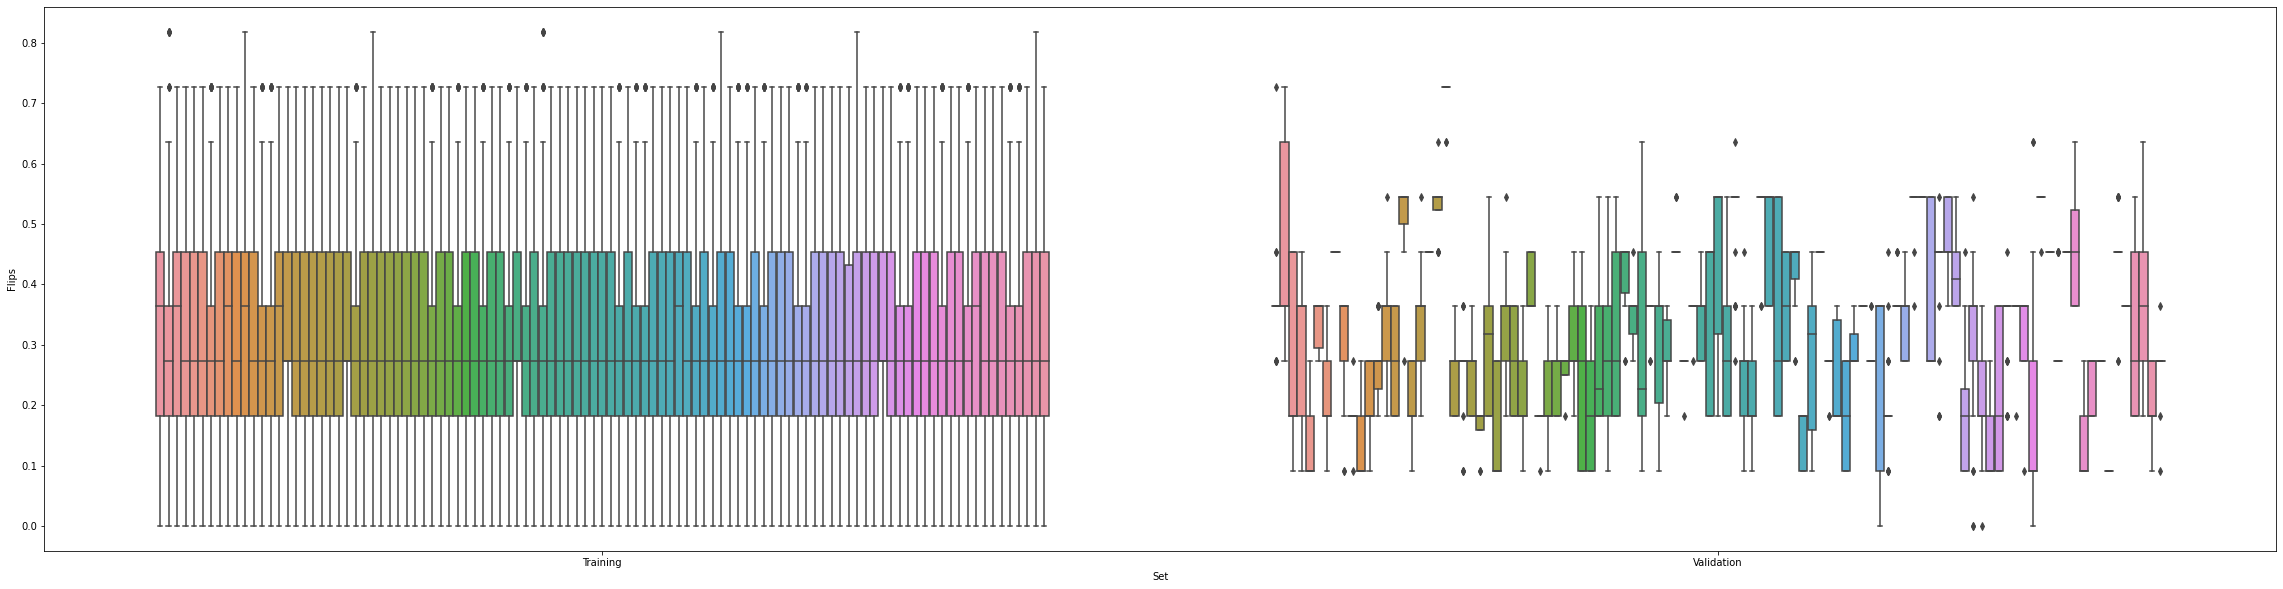

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

mega_frame = pd.concat(prediction_frames)

fig, ax = plt.subplots(figsize=(40,10))
ax = sns.boxplot(x='Set', y='Flips', data=mega_frame, hue='Inds')
plt.legend([],[], frameon=False)
plt.show()

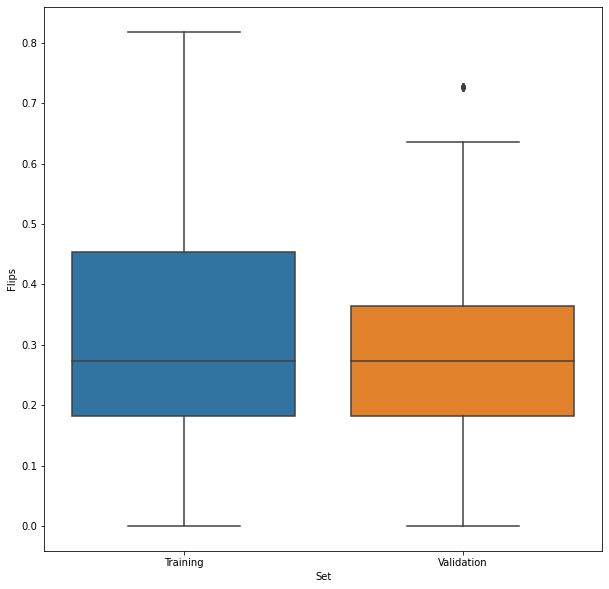

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.boxplot(x='Set', y='Flips', data=mega_frame)
plt.legend([],[], frameon=False)
plt.show()

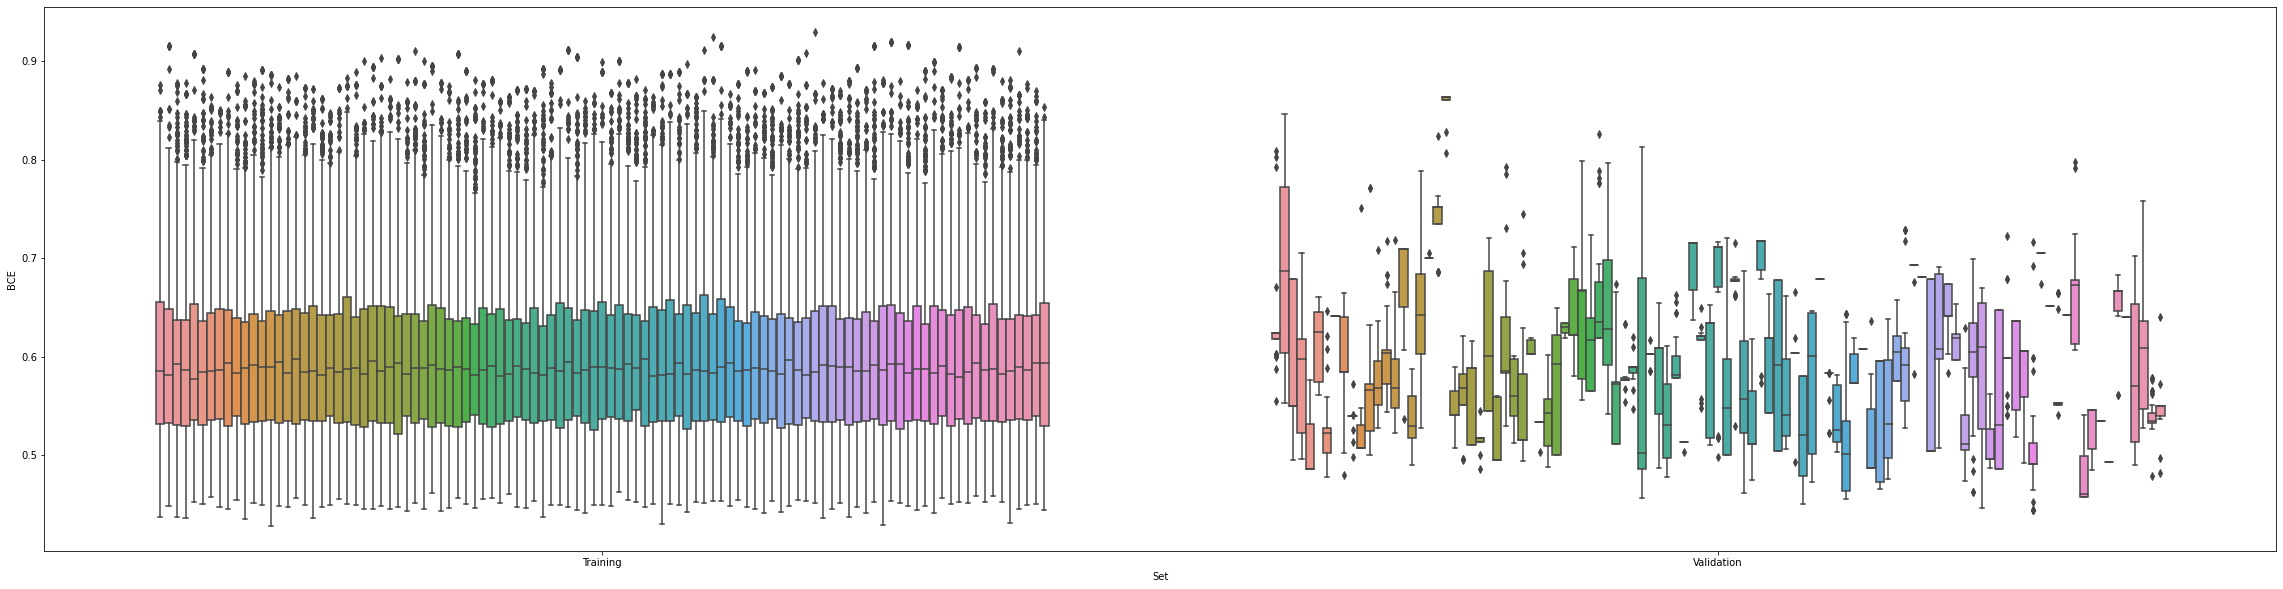

In [8]:
fig, ax = plt.subplots(figsize=(40,10))
ax = sns.boxplot(x='Set', y='BCE', data=mega_frame, hue='Inds')
plt.legend([],[], frameon=False)
plt.show()

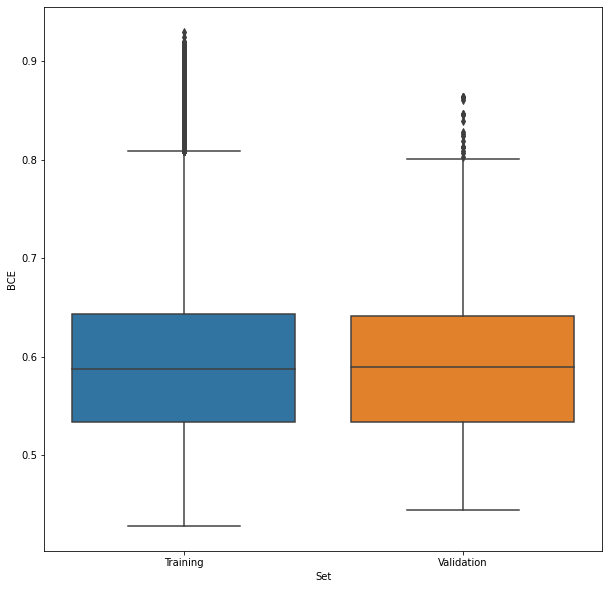

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.boxplot(x='Set', y='BCE', data=mega_frame)
plt.legend([],[], frameon=False)
plt.show()

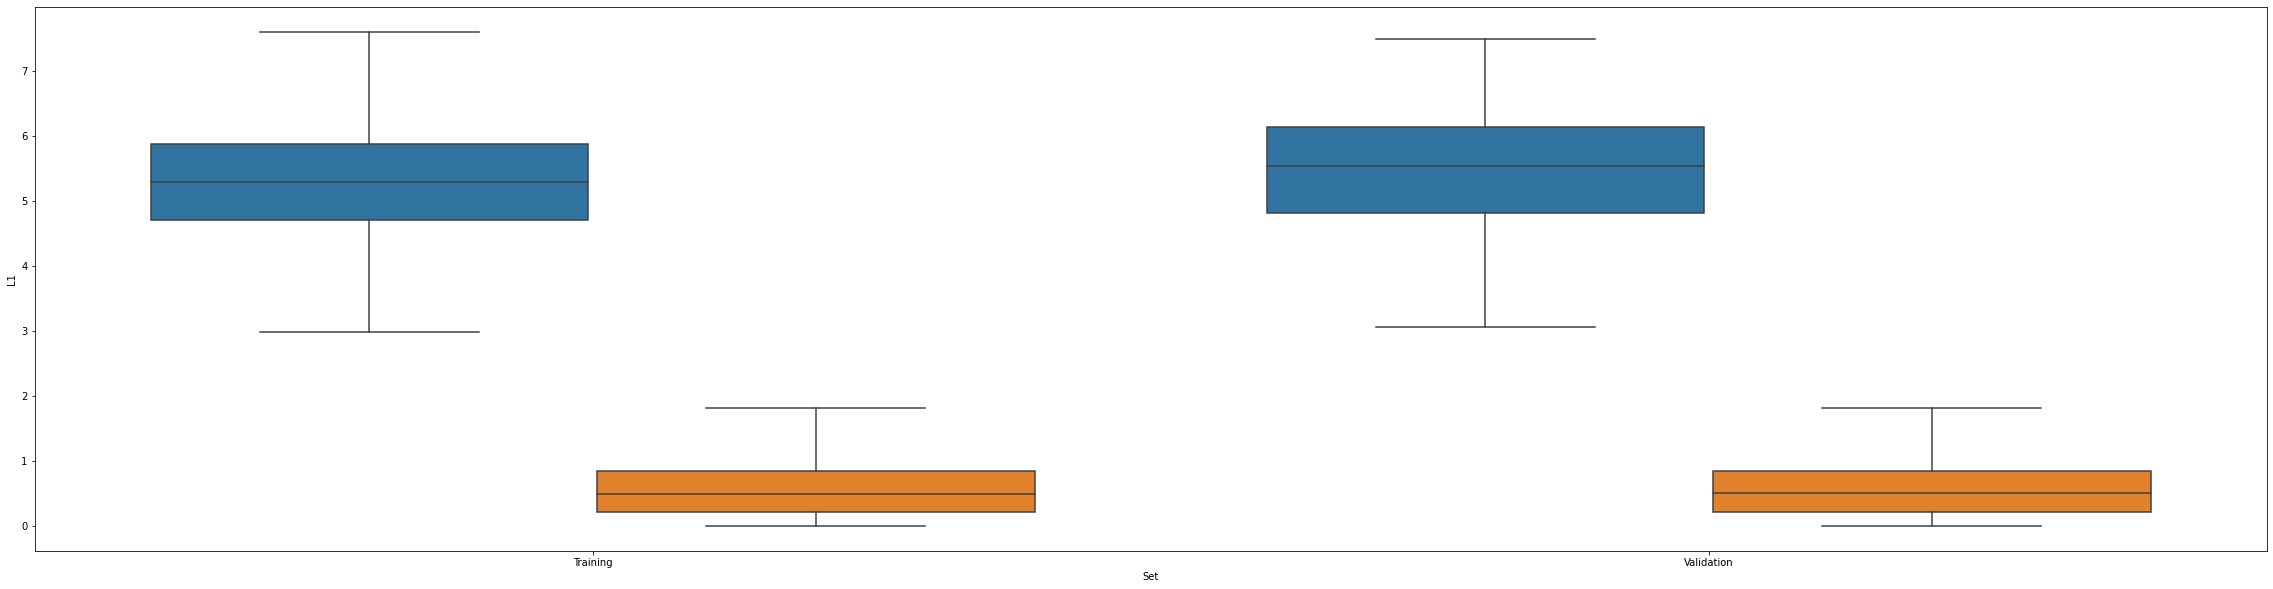

In [10]:
mega_frame_regression = pd.concat(regression_frames)

fig, ax = plt.subplots(figsize=(40,10))
ax = sns.boxplot(x='Set', y='L1', data=mega_frame_regression, hue='Battery', showfliers=False)
plt.legend([],[], frameon=False)
plt.show()

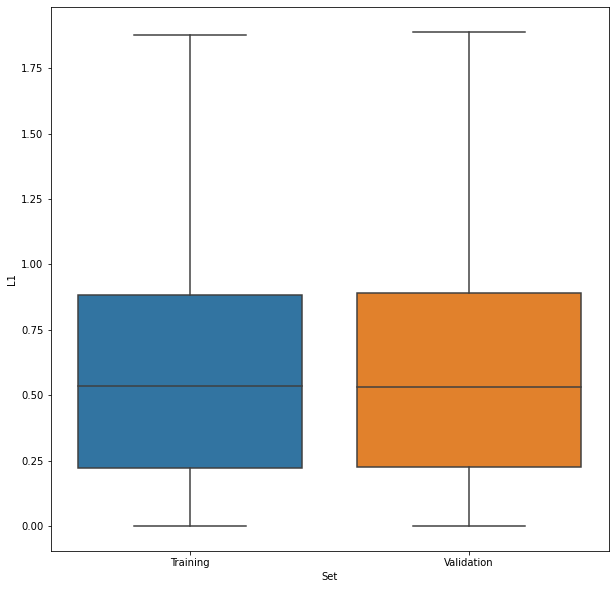

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.boxplot(x='Set', y='L1', data=mega_frame_regression, showfliers=False)
plt.legend([],[], frameon=False)
plt.show()

In [12]:
print('Notebook ran in', time.time()-start, 'seconds.')
# 19s for MLE prediction
# 806s for MAP prediction

Notebook ran in 88.8175106048584 seconds.
